In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [2]:
BATCH_SIZE = 32
HIDDEN_SIZE = 256
LOAD_MODEL = False
USE_TRANSFER_LEARNING = False

In [3]:
class Graph2VecEmbeddingsDataset(Dataset):
    """Graph2Vec Embeddings dataset."""

    def __init__(self, embeddings, labels=None, transform=None):
        """
        Args:
            embeddings (pd.dataframe): Pandas Dataframe with the graph2vec embeddings
            labels : Labels indicating intelligence for the respective individual
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.embeddings = embeddings
        self.labels = labels
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):

        sample = torch.tensor(self.embeddings.iloc[idx]).float()

        if self.labels is not None:
            return sample, torch.tensor(self.labels.iloc[idx]).float()
        else:
            return sample

In [4]:
raw_y = pd.read_csv("intelligence_label.csv")

In [5]:
raw_y

,subjectkey,nihtbx_totalcomp_uncorrected
0,NDARINV003RTV85,-0.790265
1,NDARINV007W6H7B,-0.571433
2,NDARINV00BD7VDC,0.632147
3,NDARINV00LJVZK2,0.194482
4,NDARINV00NPMHND,-0.680849
...,...,...
6907,NDARINVZZL0VA2F,-0.680849
6908,NDARINVZZLZCKAY,-0.462016
6909,NDARINVZZPKBDAC,-0.680849
6910,NDARINVZZZ2ALR6,-0.243184


In [5]:
# Read data, make fake y and drop the "type" column

#data = pd.read_csv("data/nci1.csv")
#data['y'] = np.random.normal(100,30, size=len(data))
#data = data.drop("type", axis=1)

data = pd.read_csv("features/struct_func_embedding.csv")
#cols_to_norm = data.columns#.drop("y")
#data[cols_to_norm]=(data[cols_to_norm]-data[cols_to_norm].mean())/data[cols_to_norm].std()
#data = data.dropna()

In [28]:
subjid=data['type'].values[9].split('/')[-1].split('_')[-1]

In [31]:
data['type'].values[9][-15:]

'NDARINV040B4TRC'

In [37]:
data['type'][0]

'/home/ubuntu/Stella/MLVU_multimodality/graph2vec/structural_graph_for_graph2vec_1212/graph2vec_structural_graph_NDARINV003RTV85'

In [29]:
subjid

'NDARINV040B4TRC'

In [22]:
raw_y['subjectkey'][0]

'NDARINV003RTV85'

In [6]:
y = []
for i in data['type']:
    subjid = i.split('/')[-1].split('_')[-1]
    for j in range(len(raw_y)):
        if subjid == raw_y['subjectkey'][j]:
            y.append(raw_y['nihtbx_totalcomp_uncorrected'][j])

In [7]:
len(y)

2085

In [8]:
data

,type,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_118.1,x_119.1,x_120.1,x_121.1,x_122.1,x_123.1,x_124.1,x_125.1,x_126.1,x_127.1
0,/home/ubuntu/Stella/MLVU_multimodality/graph2v...,-0.060564,-0.090097,0.017879,-0.233405,-0.031025,-0.161997,-0.110498,-0.106946,0.161249,...,-0.058875,-0.045145,-0.035233,0.033590,-0.003432,0.033996,0.029607,0.008686,-0.028766,0.067319
1,/home/ubuntu/Stella/MLVU_multimodality/graph2v...,-0.058420,-0.086559,0.019345,-0.226949,-0.031319,-0.155380,-0.109569,-0.100978,0.149402,...,-0.024165,-0.021222,-0.019916,0.022018,0.003037,0.020805,0.014551,0.007052,-0.009735,0.033356
2,/home/ubuntu/Stella/MLVU_multimodality/graph2v...,-0.066414,-0.084501,0.019682,-0.234007,-0.033996,-0.160188,-0.116341,-0.105766,0.160227,...,-0.150266,-0.102514,-0.109775,0.158490,-0.032627,0.073411,0.106722,0.041687,-0.089557,0.197947
3,/home/ubuntu/Stella/MLVU_multimodality/graph2v...,-0.061569,-0.079573,0.018303,-0.221120,-0.028189,-0.150833,-0.103980,-0.096945,0.152231,...,-0.288406,-0.231228,-0.167932,0.187091,-0.006038,0.168102,0.160195,0.068691,-0.139464,0.327302
4,/home/ubuntu/Stella/MLVU_multimodality/graph2v...,-0.063210,-0.087080,0.025141,-0.234608,-0.028360,-0.162248,-0.116670,-0.104763,0.154640,...,0.030238,0.018195,0.016880,-0.020034,0.002513,-0.019045,-0.013067,-0.003425,0.016418,-0.028255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080,/home/ubuntu/Stella/MLVU_multimodality/graph2v...,-0.052150,-0.077419,0.014720,-0.209189,-0.026127,-0.145545,-0.099978,-0.094635,0.141908,...,0.019741,0.016145,0.010044,-0.016801,-0.002833,-0.017898,-0.013662,-0.002859,0.011401,-0.028907
2081,/home/ubuntu/Stella/MLVU_multimodality/graph2v...,-0.056559,-0.080355,0.022327,-0.229628,-0.029295,-0.160573,-0.113333,-0.101679,0.155368,...,-0.042761,-0.035346,-0.021141,0.032329,0.001603,0.024632,0.020912,0.010401,-0.017409,0.050803
2082,/home/ubuntu/Stella/MLVU_multimodality/graph2v...,-0.059904,-0.084092,0.022182,-0.218934,-0.033377,-0.157618,-0.110358,-0.098928,0.148119,...,-0.280970,-0.237530,-0.150155,0.182934,-0.006497,0.166452,0.146688,0.059213,-0.125576,0.341123
2083,/home/ubuntu/Stella/MLVU_multimodality/graph2v...,-0.062419,-0.086961,0.018969,-0.241844,-0.030937,-0.168730,-0.120848,-0.102684,0.162021,...,-0.223731,-0.166204,-0.126386,0.149962,-0.006443,0.134264,0.123120,0.053563,-0.104671,0.250376


In [9]:
data['y'] = y
data = data.drop("type", axis=1)

In [10]:
data

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_119.1,x_120.1,x_121.1,x_122.1,x_123.1,x_124.1,x_125.1,x_126.1,x_127.1,y
0,-0.060564,-0.090097,0.017879,-0.233405,-0.031025,-0.161997,-0.110498,-0.106946,0.161249,-0.466659,...,-0.045145,-0.035233,0.033590,-0.003432,0.033996,0.029607,0.008686,-0.028766,0.067319,-0.790265
1,-0.058420,-0.086559,0.019345,-0.226949,-0.031319,-0.155380,-0.109569,-0.100978,0.149402,-0.449210,...,-0.021222,-0.019916,0.022018,0.003037,0.020805,0.014551,0.007052,-0.009735,0.033356,-0.680849
2,-0.066414,-0.084501,0.019682,-0.234007,-0.033996,-0.160188,-0.116341,-0.105766,0.160227,-0.463173,...,-0.102514,-0.109775,0.158490,-0.032627,0.073411,0.106722,0.041687,-0.089557,0.197947,0.632147
3,-0.061569,-0.079573,0.018303,-0.221120,-0.028189,-0.150833,-0.103980,-0.096945,0.152231,-0.431845,...,-0.231228,-0.167932,0.187091,-0.006038,0.168102,0.160195,0.068691,-0.139464,0.327302,-0.133767
4,-0.063210,-0.087080,0.025141,-0.234608,-0.028360,-0.162248,-0.116670,-0.104763,0.154640,-0.459196,...,0.018195,0.016880,-0.020034,0.002513,-0.019045,-0.013067,-0.003425,0.016418,-0.028255,-0.243184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080,-0.052150,-0.077419,0.014720,-0.209189,-0.026127,-0.145545,-0.099978,-0.094635,0.141908,-0.413155,...,0.016145,0.010044,-0.016801,-0.002833,-0.017898,-0.013662,-0.002859,0.011401,-0.028907,0.194482
2081,-0.056559,-0.080355,0.022327,-0.229628,-0.029295,-0.160573,-0.113333,-0.101679,0.155368,-0.451812,...,-0.035346,-0.021141,0.032329,0.001603,0.024632,0.020912,0.010401,-0.017409,0.050803,1.179229
2082,-0.059904,-0.084092,0.022182,-0.218934,-0.033377,-0.157618,-0.110358,-0.098928,0.148119,-0.439615,...,-0.237530,-0.150155,0.182934,-0.006497,0.166452,0.146688,0.059213,-0.125576,0.341123,-0.462016
2083,-0.062419,-0.086961,0.018969,-0.241844,-0.030937,-0.168730,-0.120848,-0.102684,0.162021,-0.471974,...,-0.166204,-0.126386,0.149962,-0.006443,0.134264,0.123120,0.053563,-0.104671,0.250376,-0.024351


In [11]:
train_df, test_df = np.split(data.sample(frac=1, random_state=42), [int(.9*len(data))])

In [12]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(train_df.iloc[:, 1:], train_df['y'], test_size=1/9, random_state=42)

In [13]:
y_test = test_df["y"]
X_test = test_df.drop("y", axis=1)

In [14]:
train_dataset = Graph2VecEmbeddingsDataset(embeddings=X_train, labels=y_train)
valid_dataset = Graph2VecEmbeddingsDataset(embeddings=X_valid, labels=y_valid)
test_dataset = Graph2VecEmbeddingsDataset(embeddings=X_test, labels=y_test)

In [15]:
train_dataset[5]

(tensor([-7.9102e-02,  2.0204e-02, -2.2370e-01, -2.5999e-02, -1.5400e-01,
         -1.0596e-01, -9.7772e-02,  1.5631e-01, -4.4454e-01, -1.5771e-01,
          1.0530e-01,  1.6490e-01, -1.2046e-01, -1.8206e-02, -7.4203e-02,
          1.3171e-01, -1.3311e-02, -3.4454e-02,  1.8862e-02,  8.6579e-02,
         -3.6196e-02, -1.5377e-01, -8.7003e-02,  1.1346e-01,  1.4836e-01,
         -6.8907e-02,  1.2097e-01, -9.2794e-02, -2.4053e-01,  3.6288e-02,
          8.3222e-02,  2.0930e-01,  1.2530e-01,  1.2664e-01,  4.9676e-02,
          1.9926e-01,  3.3828e-02,  1.0633e-02, -1.7350e-02, -4.0538e-02,
          5.8536e-02, -1.3925e-02, -1.3536e-01,  1.1092e-02,  8.0238e-02,
         -8.8536e-02,  3.1406e-02,  1.9980e-01, -1.1908e-01,  5.5592e-02,
          3.5060e-02, -2.9032e-02,  1.2752e-01,  6.8406e-02, -5.0526e-02,
         -9.7237e-02, -6.5772e-02, -1.8961e-01,  4.7921e-02,  1.2261e-01,
          1.3266e-01,  1.1303e-01, -2.9141e-01,  1.5893e-01,  2.8280e-02,
         -1.3573e-01,  3.9146e-02,  8.

In [16]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
dataiter = iter(train_loader)
embeddings, labels = dataiter.next()

print('embeddings shape on PyTroch : ', embeddings.size())
print('labels shape on PyTroch : ', labels.size())

embeddings shape on PyTroch :  torch.Size([32, 256])
labels shape on PyTroch :  torch.Size([32])


In [58]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
        
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1)
        )
        
        self.layers.apply(init_weights)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [59]:
model = MLP(embeddings.size()[1], 256)

if LOAD_MODEL:
    model.load_state_dict(torch.load(PATH))
    
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss() #will calculate RMSE next line

In [60]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 200

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, (embeddings, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        outputs = model(embeddings)
        
        #print("Embeddings: ", embeddings, " Output: ", outputs, " Labels: ", labels.view(-1,1))
        
        loss = torch.sqrt(loss_fn(outputs, labels.view(-1,1)))
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
            
    model.eval()
    
    with torch.no_grad():
        for i, (embeddings, labels) in enumerate(valid_loader):
            outputs = model(embeddings)
            loss = torch.sqrt(loss_fn(outputs, labels.view(-1,1)))
            
            valid_losses.append(loss.item())
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses)))

epoch : 1, train loss : 1.2094, valid loss : 0.5184
epoch : 2, train loss : 1.2072, valid loss : 0.5349
epoch : 3, train loss : 1.1859, valid loss : 0.5646
epoch : 4, train loss : 1.2068, valid loss : 0.5349
epoch : 5, train loss : 1.2064, valid loss : 0.5623
epoch : 6, train loss : 1.2010, valid loss : 0.5559
epoch : 7, train loss : 1.1819, valid loss : 0.5418
epoch : 8, train loss : 1.1938, valid loss : 0.6033
epoch : 9, train loss : 1.1523, valid loss : 0.5535
epoch : 10, train loss : 1.1856, valid loss : 0.5437
epoch : 11, train loss : 1.2262, valid loss : 0.5099
epoch : 12, train loss : 1.1933, valid loss : 0.5519
epoch : 13, train loss : 1.2100, valid loss : 0.5701
epoch : 14, train loss : 1.1837, valid loss : 0.5635
epoch : 15, train loss : 1.1953, valid loss : 0.5767
epoch : 16, train loss : 1.2164, valid loss : 0.5977
epoch : 17, train loss : 1.2196, valid loss : 0.5625
epoch : 18, train loss : 1.2304, valid loss : 0.5311
epoch : 19, train loss : 1.2057, valid loss : 0.5619
ep

epoch : 155, train loss : 1.2304, valid loss : 0.5719
epoch : 156, train loss : 1.2172, valid loss : 0.5792
epoch : 157, train loss : 1.2017, valid loss : 0.5546
epoch : 158, train loss : 1.1738, valid loss : 0.5411
epoch : 159, train loss : 1.1751, valid loss : 0.5796
epoch : 160, train loss : 1.1709, valid loss : 0.5843
epoch : 161, train loss : 1.1988, valid loss : 0.5305
epoch : 162, train loss : 1.1891, valid loss : 0.5724
epoch : 163, train loss : 1.2277, valid loss : 0.5770
epoch : 164, train loss : 1.1821, valid loss : 0.6067
epoch : 165, train loss : 1.1844, valid loss : 0.5076
epoch : 166, train loss : 1.1813, valid loss : 0.5485
epoch : 167, train loss : 1.2011, valid loss : 0.5347
epoch : 168, train loss : 1.1817, valid loss : 0.5595
epoch : 169, train loss : 1.1936, valid loss : 0.5571
epoch : 170, train loss : 1.1906, valid loss : 0.5697
epoch : 171, train loss : 1.2107, valid loss : 0.5911
epoch : 172, train loss : 1.2117, valid loss : 0.5374
epoch : 173, train loss : 1.

In [46]:
torch.save(model.state_dict(), "models/multichannel_graph2vec_MLP_with_dropout_543_v2")

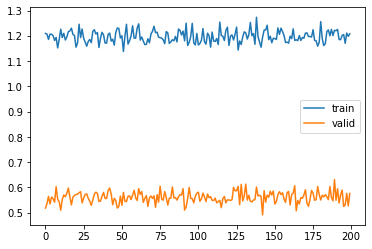

In [61]:
fig, ax = plt.subplots()
ax.plot(mean_train_losses, label='train')
ax.plot(mean_valid_losses, label='valid')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

plt.show()

In [63]:
model.eval()
test_losses = []
for i, (embeddings, labels) in enumerate(test_loader):
    
    pred = model(embeddings)
    loss = torch.sqrt(loss_fn(pred, labels.view(-1,1)))
    #print("Prediction:", pred.detach().numpy(), " Ground Truth:", labels.view(-1,1))
    test_losses.append(loss.item())
print("average test loss:", np.mean(test_losses))
print("average valid loss:", np.mean(mean_valid_losses))
print("average train loss:", np.mean(mean_train_losses))

average test loss: 2.206455264772688
average valid loss: 0.5609226760481085
average train loss: 1.197193994508037


In [52]:
from sklearn.metrics import r2_score
r2_score_average = []
for i, (embeddings, labels) in enumerate(test_loader):
    
    pred = model(embeddings)
    
    r2_score_average.append(r2_score(labels.view(-1,1).detach().numpy(),pred.detach().numpy()))
print("average r2_score:", np.mean(r2_score_average))

average r2_score: -1.6409089133775399


In [50]:
from sklearn.metrics import r2_score

r2_score(labels.view(-1,1).detach().numpy(),pred.detach().numpy())

-1.1131735504783182

### dropout - 0.5 0.4 0.3
average test loss: 0.8273464867046901
??
??

### dropout - 0.5 0.4 0.2
average test loss: 0.8660806587764195
average valid loss: 0.6826670368654387
average train loss: 1.1280021055520706